In [1]:
import json
import pandas as pd
import itertools
import csv
import pickle
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score



In [2]:
plt.style.use('seaborn')

In [3]:
pkl_path = '/Users/xzhou/github/project_files/amazon/amazon_alexa_reviews.pkl'

with open(pkl_path, 'rb') as pkl_file:
    df = pd.read_pickle(pkl_file)

df.head()

,rating,date,review,review_by_word,word_count
2,4,2018-07-31,"Sometimes while playing a game, you can answer...","[Sometimes, while, playing, a, game, ,, you, c...",41
3,5,2018-07-31,I have had a lot of fun with this thing. My 4 ...,"[I, have, had, a, lot, of, fun, with, this, th...",38
5,5,2018-07-31,I received the echo as a gift. I needed anothe...,"[I, received, the, echo, as, a, gift, ., I, ne...",38
6,3,2018-07-31,"Without having a cellphone, I cannot use many ...","[Without, having, a, cellphone, ,, I, can, not...",84
7,5,2018-07-31,I think this is the 5th one I've purchased. I'...,"[I, think, this, is, the, 5th, one, I, 've, pu...",45


In [4]:
df.shape

(7248, 5)

In [5]:
# Assign sentiment:

def assign_sentiment(x):
    sentiment = ''
    if x < 3:
        sentiment = -1
    elif x == 3:
        sentiment = 0
    else:
        sentiment =1
    return sentiment

In [6]:
df['sentiment'] = df['rating'].apply(lambda x: assign_sentiment(x))

In [7]:
X = df['review']

In [8]:
y = df['sentiment']

In [232]:
class KMeansEngine:
    def __init__(self, data, vectorizer_name, max_df_, min_df_, vector_max_features_):
        """
        The function supports tfidf and count vecotrizer only. Please select 'tiidf' or 'count'
        for vecotrizer. Provided with desired arguments, it will create a vector, 
        and vectorize data
        """
        self.vector_max_features = vector_max_features_
        self.vectorizer(vectorizer_name, max_df_, min_df_)
        self.vectorize_data(data)
            
    
    def vectorizer(self, vectorizer_name, max_df_, min_df_):
        """
        The function supports tfidf and count vecotrizer only. Provided with desired
        argument, return a vector
        """
        if vectorizer_name.lower() == 'tfidf':
            self.vector = TfidfVectorizer(ngram_range=(1,2),
                               stop_words='english',
                               token_pattern="\\b[a-z][a-z]+\\b",
                               lowercase=True,
                               max_df=max_df_,
                               min_df=min_df_,
                               max_features=self.vector_max_features)
            return self.vector
        
        elif vectorizer_name.lower() == 'count':
            self.vector = CountVectorizer(ngram_range=(1,2),
                               stop_words='english',
                               token_pattern="\\b[a-z][a-z]+\\b",
                               lowercase=True,
                               max_df=max_df_,
                               min_df=min_df_,
                               max_features=self.vector_max_features)
            return self.vector
        
        else:
            return 'error'
        
    
    def vectorize_data(self, data):
        """
        Return vectorized data using specificed vector
        """
        self.vectorized_data = self.vector.fit_transform(data)       
        return self.vectorized_data
    
    def dimension_reduction (self, reduction_method, reduction_max_features_):
        """
        Support svd and nmf only.
        """
        if reduction_method.lower() == 'svd':
            lsa = TruncatedSVD(n_components=reduction_max_features_)
            self.reduced_data = lsa.fit_transform(self.vectorized_data)
            
        elif reduction_method.lower() == 'nmf':
            nmf = NMF(n_components=reduction_max_features_)
            self.reduced_data = nmf.fit_transform(self.vectorized_data)
            
        return self.reduced_data
            
    
    def KMeans_iterations(self, max_num_clusters):
        """
        Perform Kmeans fit from 2 to maximum number of clusters specified,
        return sil score and SSE for each number of cluster 
        """
        self.Sil_coefs = []
        self.SSEs = []
        self.k_clusters = range(2, max_num_clusters+1)

        for k in range(2, max_num_clusters+1):
            km = KMeans(n_clusters=k, random_state=99, n_jobs=-1)
            km.fit(self.reduced_data)
            labels = km.labels_
            self.Sil_coefs.append(silhouette_score(self.reduced_data, labels, metric='euclidean'))
            self.SSEs.append(km.inertia_) 
  
            
    def draw_KMeans_plot(self):
        """
        Plot two subplots for Sil_coefficients, and SSEs
        """

        fig, ax = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)

        ax[0].plot(self.k_clusters, self.Sil_coefs)
        ax[0].set_xlabel('number of clusters')
        ax[0].set_ylabel('Silhouette coefficient')

        ax[1].plot(self.k_clusters, self.SSEs)
        ax[1].set_xlabel('number of clusters')
        ax[1].set_ylabel('SSE')
        
        

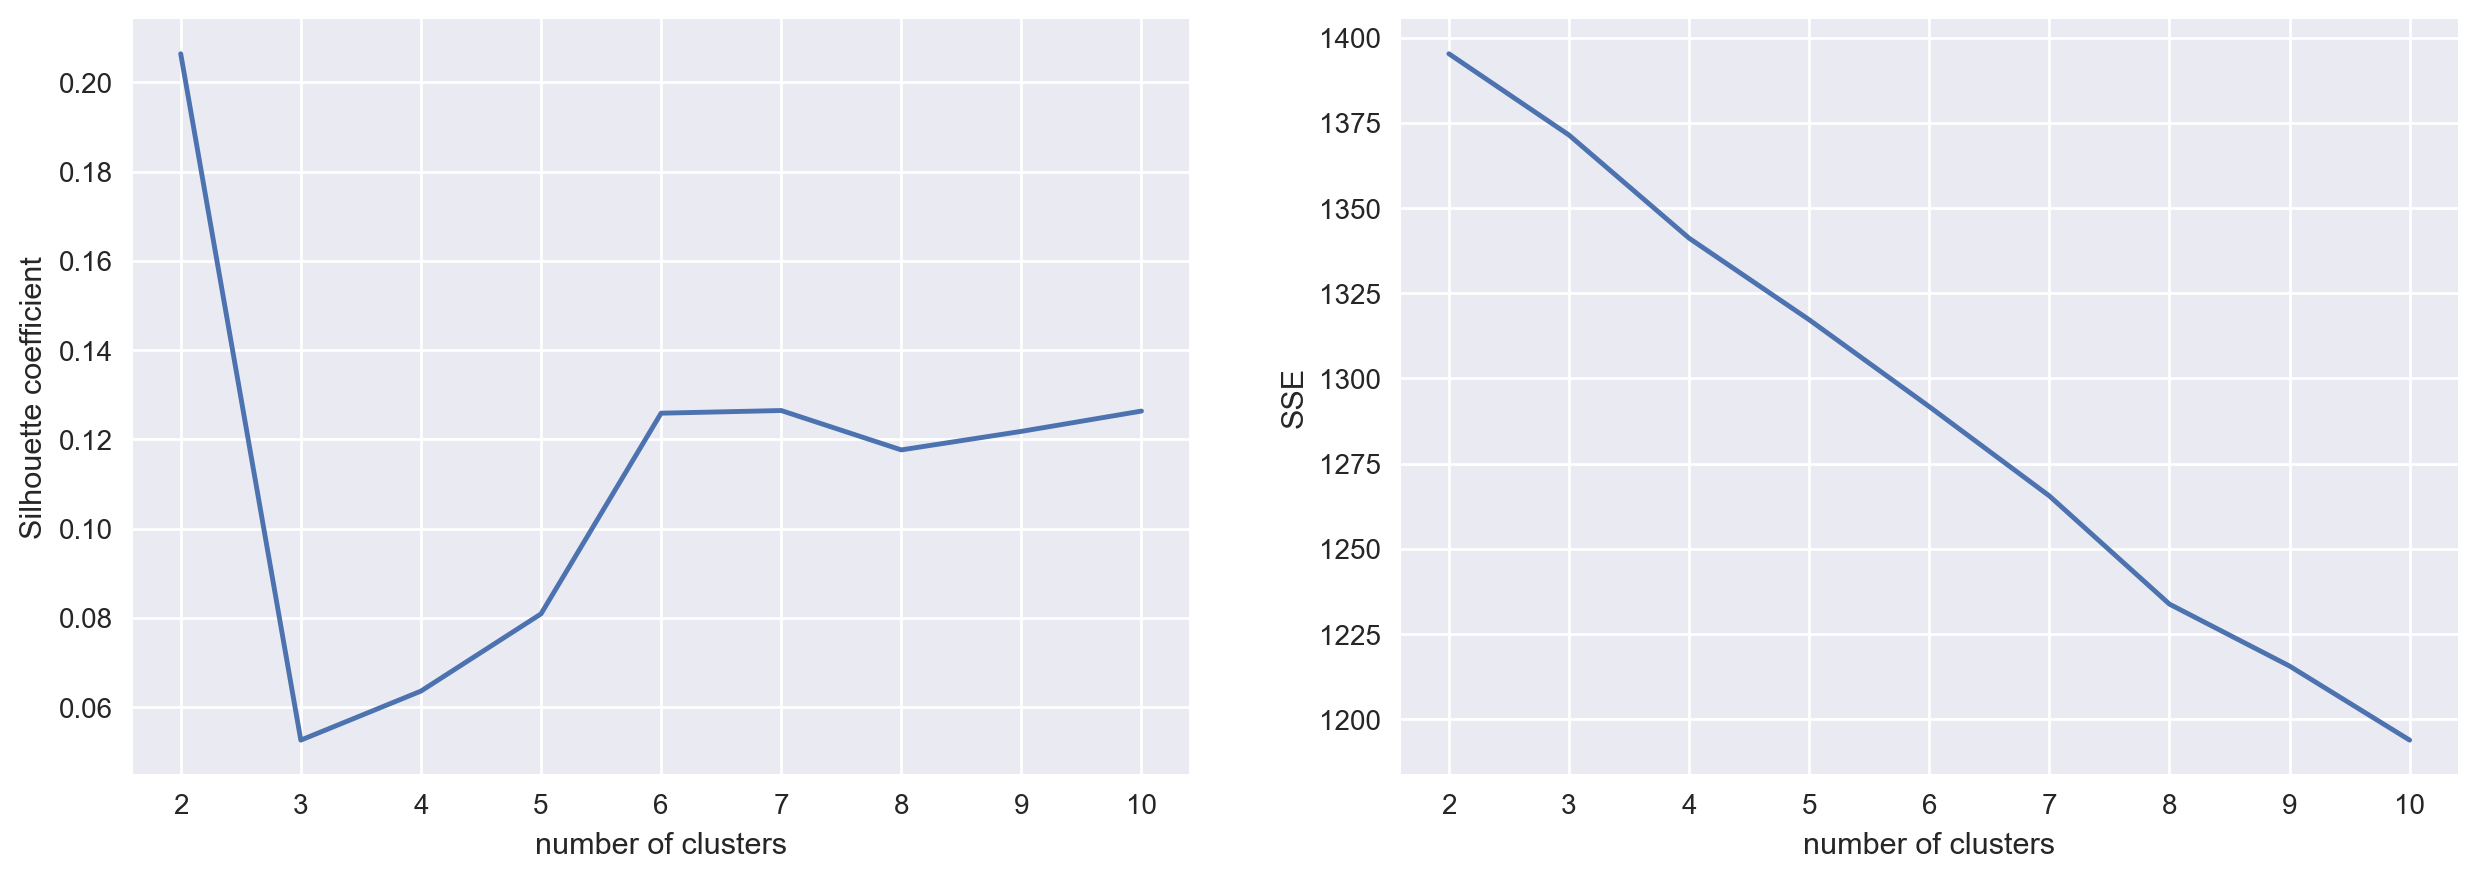

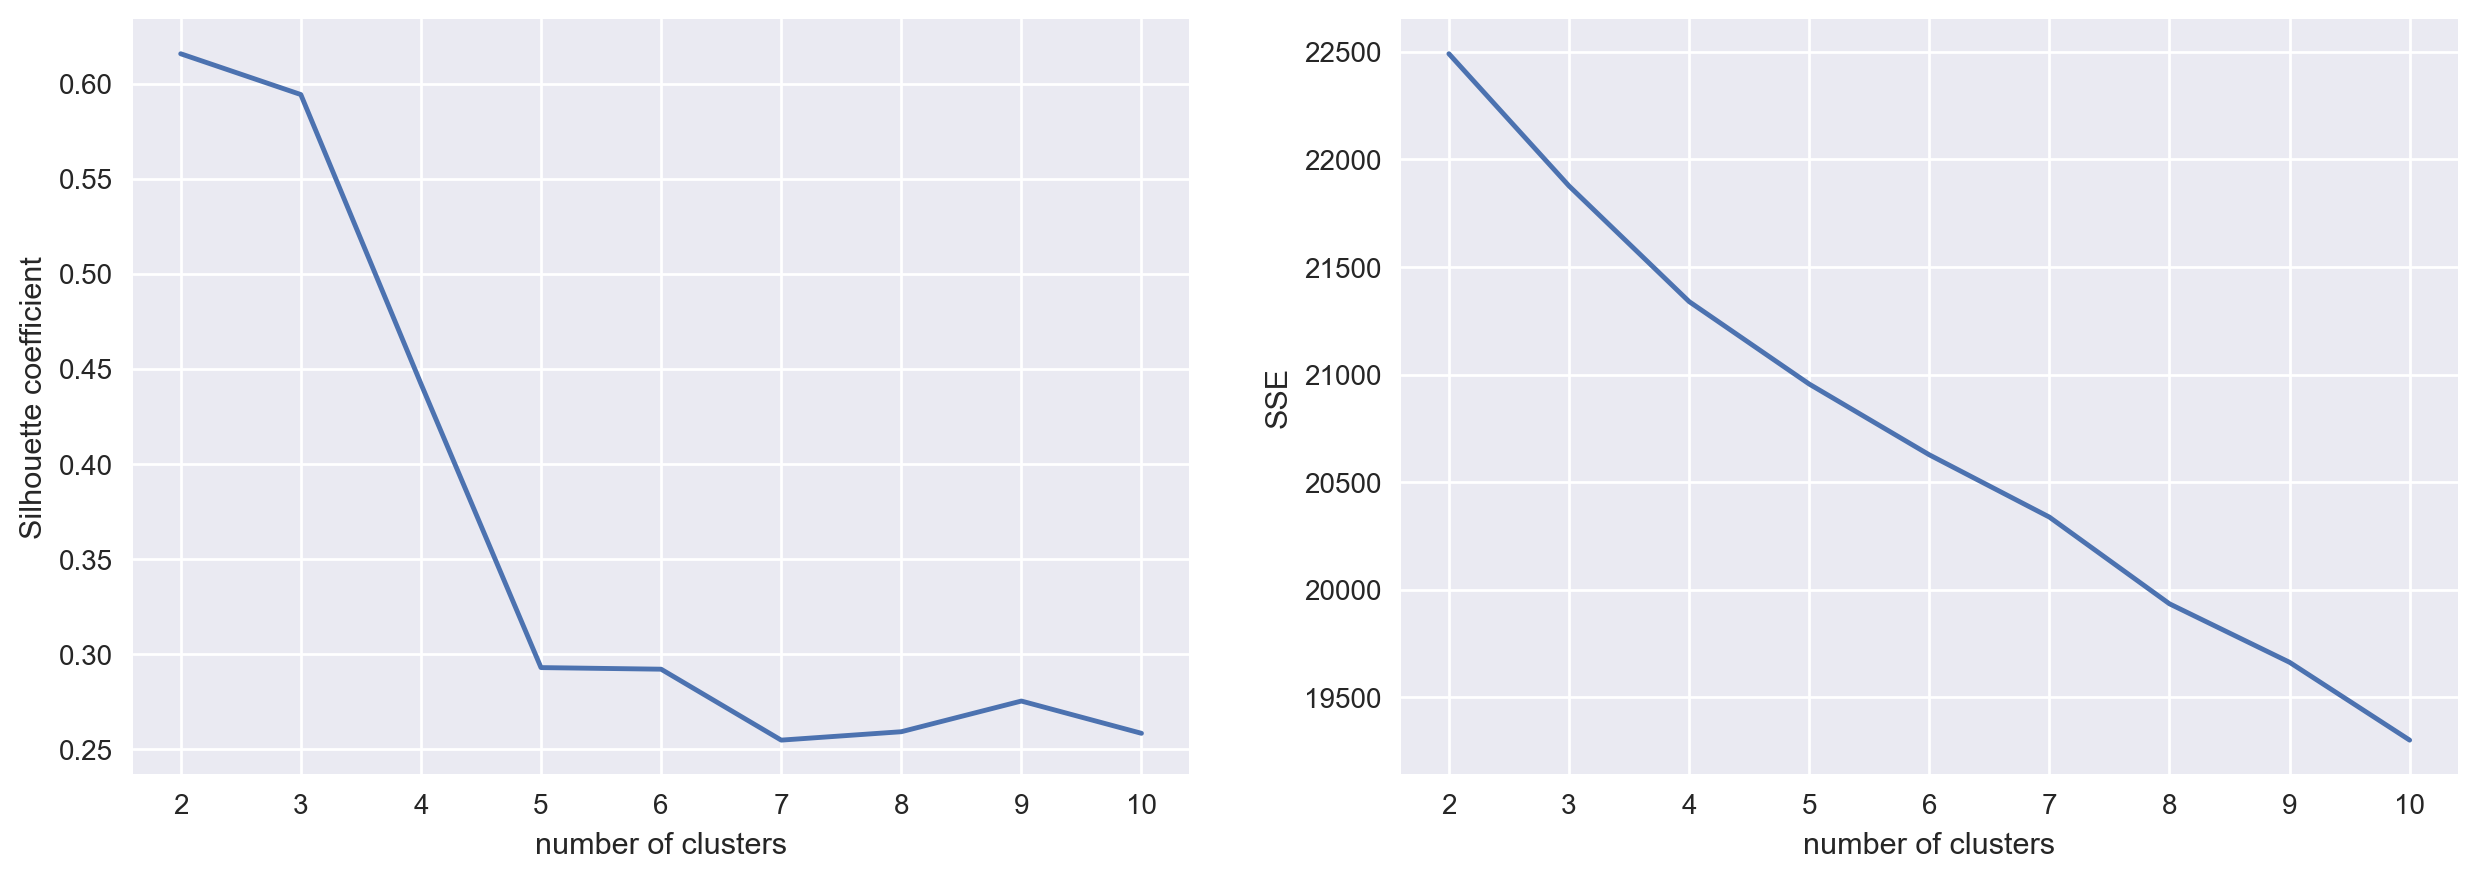

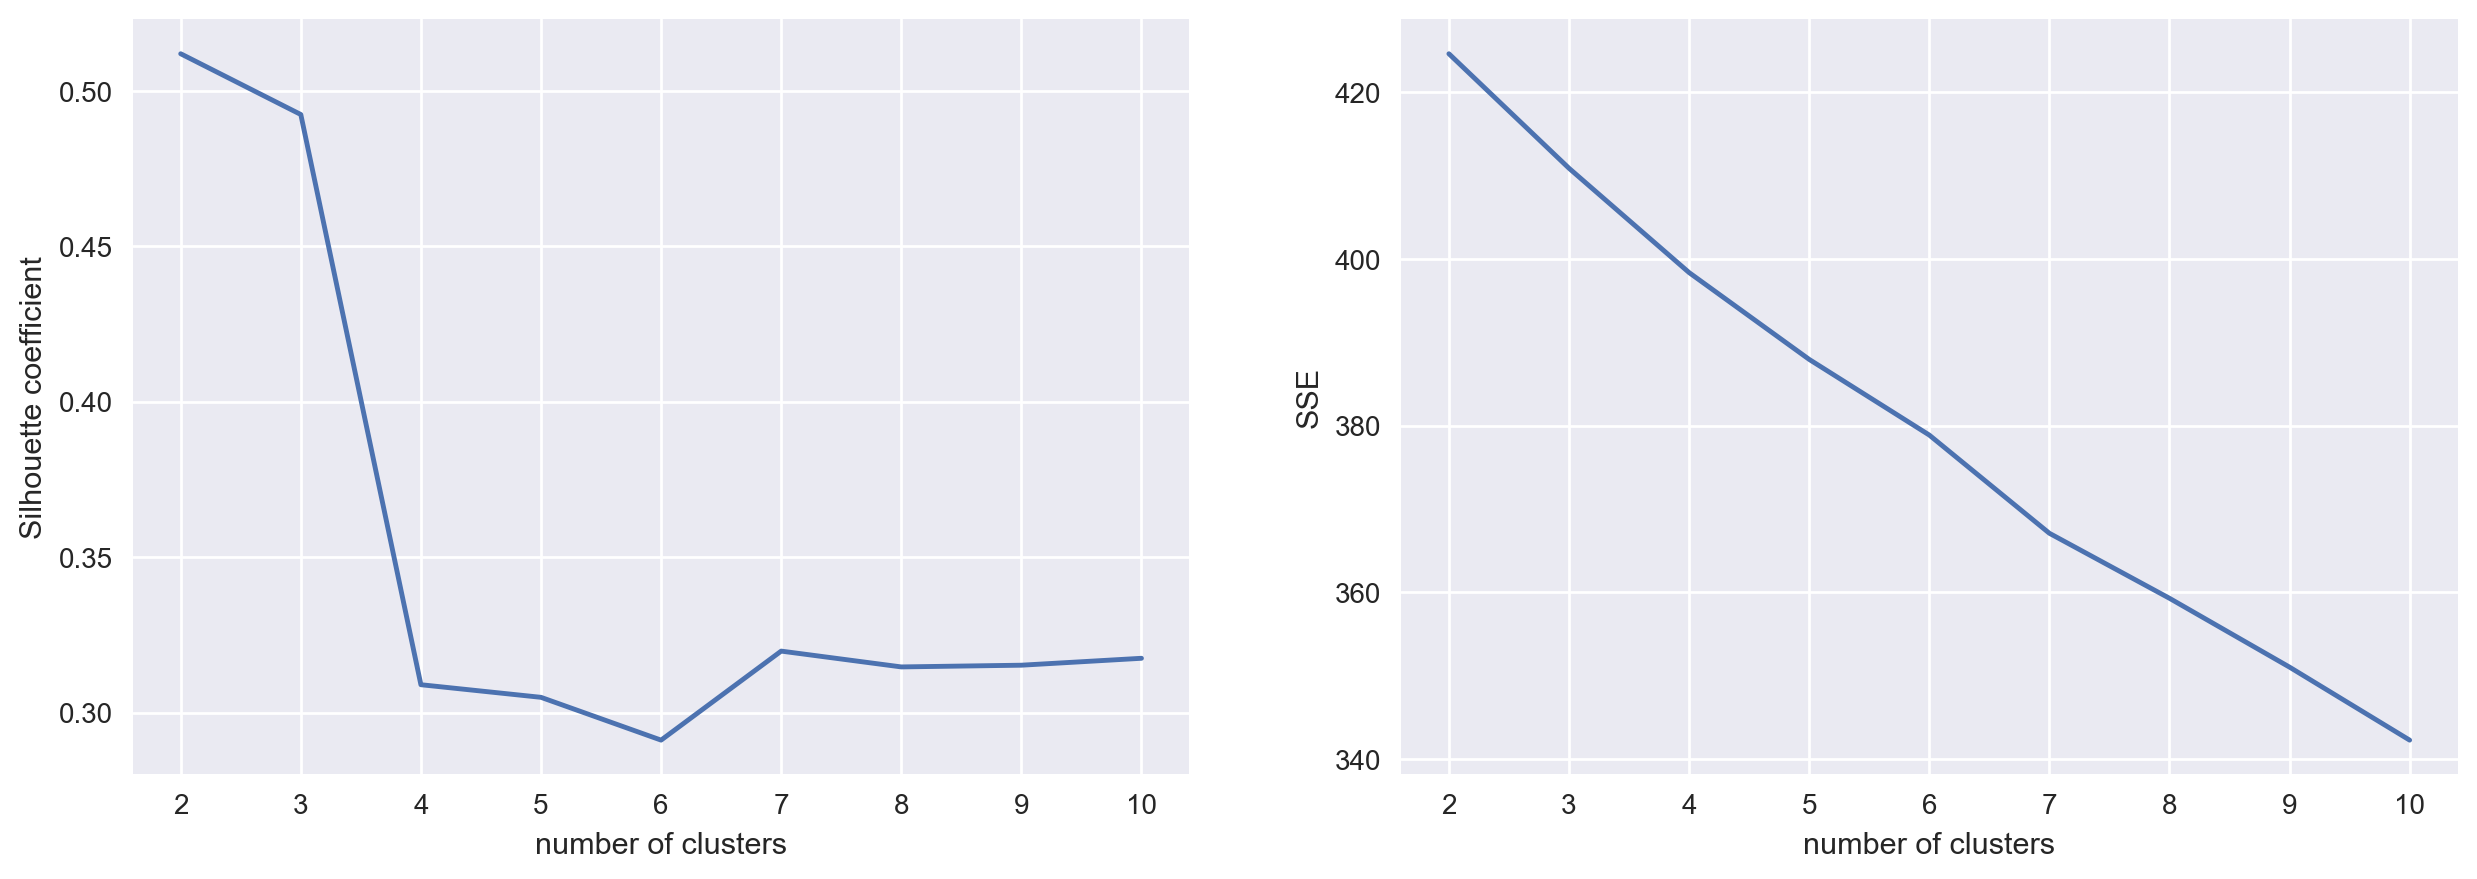

In [233]:
# min_df=0.002, max_feature =50

# Case 1: 'tfidf', 'svd', min_df=0.002, reduced_features=100
lsa_tfidf_0002_50 = KMeansEngine(X, 'tfidf', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_tfidf_0002_50.dimension_reduction('svd', reduction_max_features_=50)
lsa_tfidf_0002_50.KMeans_iterations(10)


# Case 2: 'count', 'svd', min_df=0.002, reduced_features=100
lsa_cv_0002_50 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_cv_0002_50.dimension_reduction('svd', reduction_max_features_=50)
lsa_cv_0002_50.KMeans_iterations(10)


# Case 3: 'count', 'nmf', min_df=0.002, reduced_features=100
nmf_cv_0002_50 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
nmf_cv_0002_50.dimension_reduction('nmf', reduction_max_features_=50)
nmf_cv_0002_50.KMeans_iterations(10)


# Plot for all three cases
lsa_tfidf_0002_50.draw_KMeans_plot()
lsa_cv_0002_50.draw_KMeans_plot()
nmf_cv_0002_50.draw_KMeans_plot()

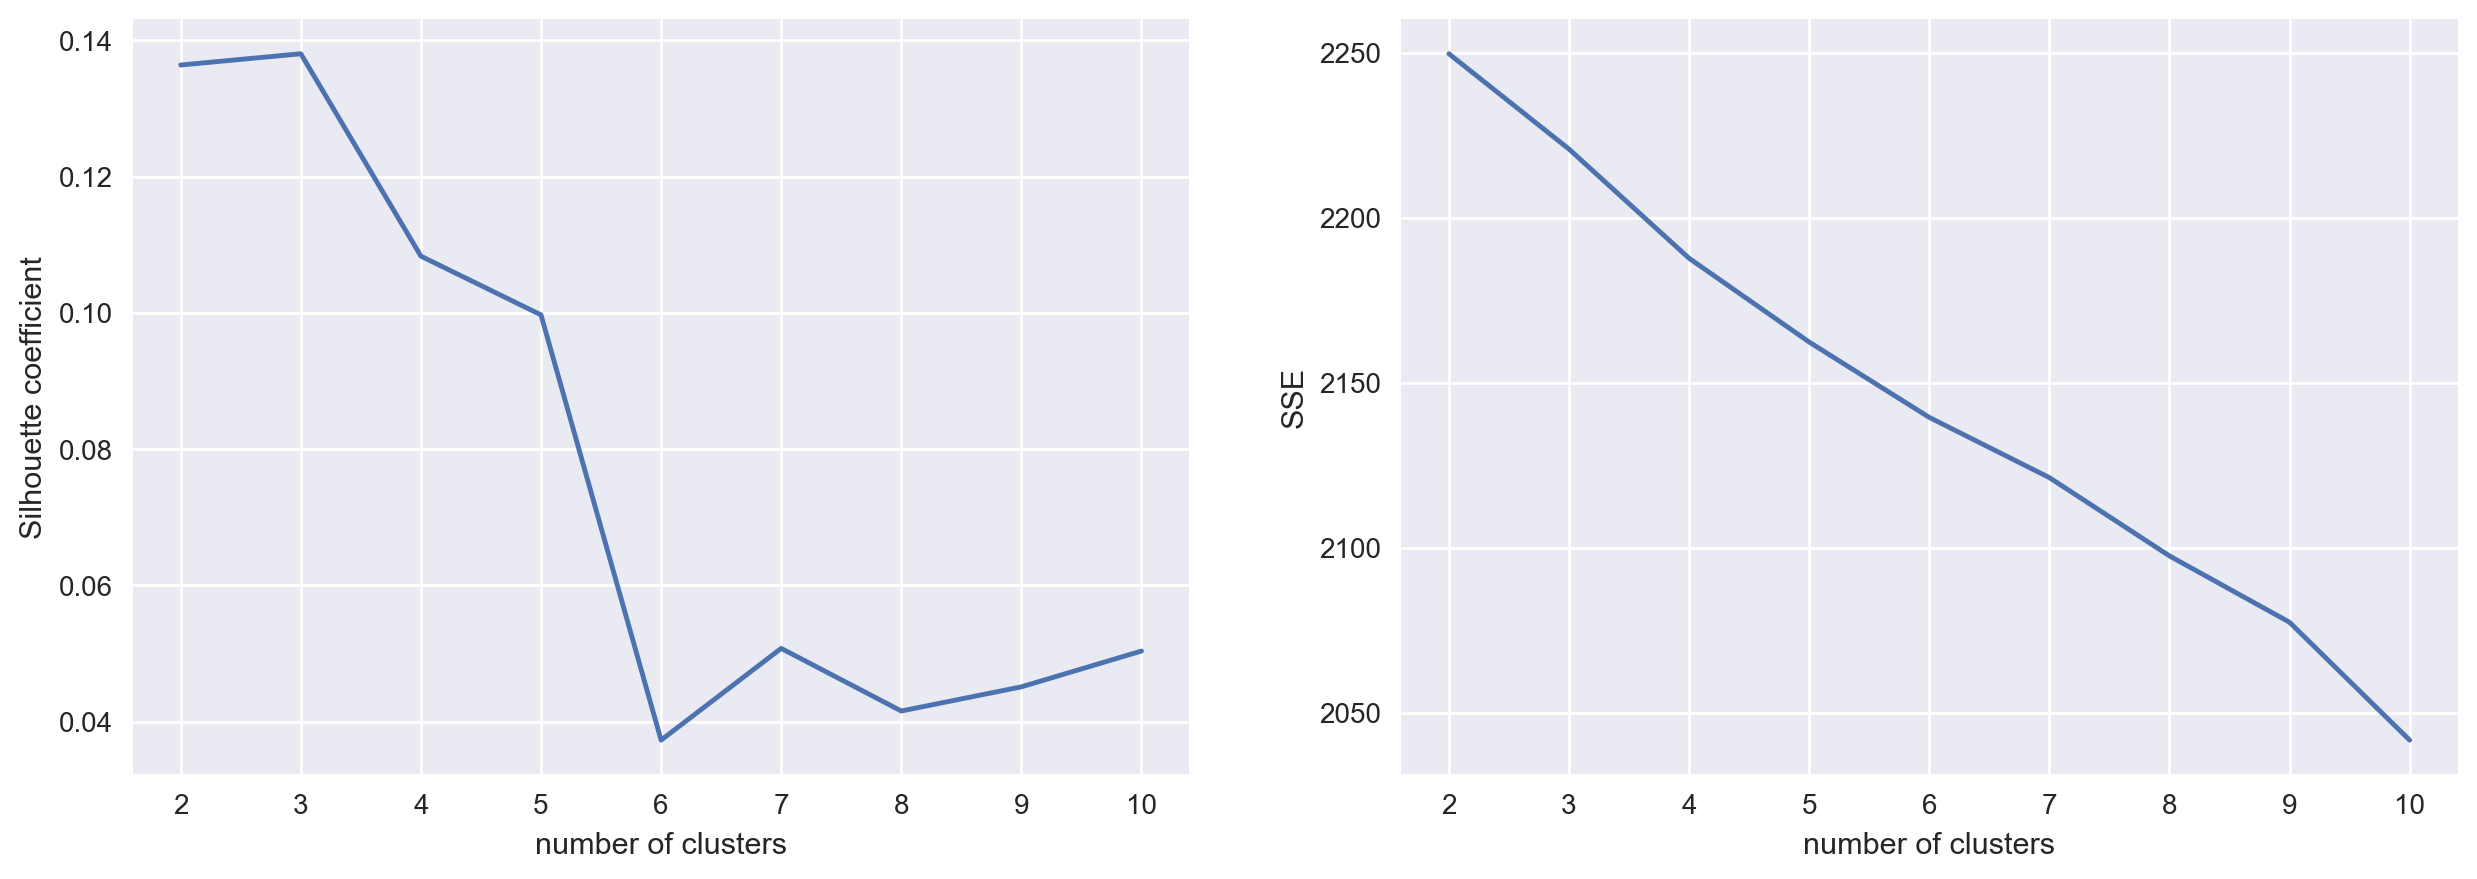

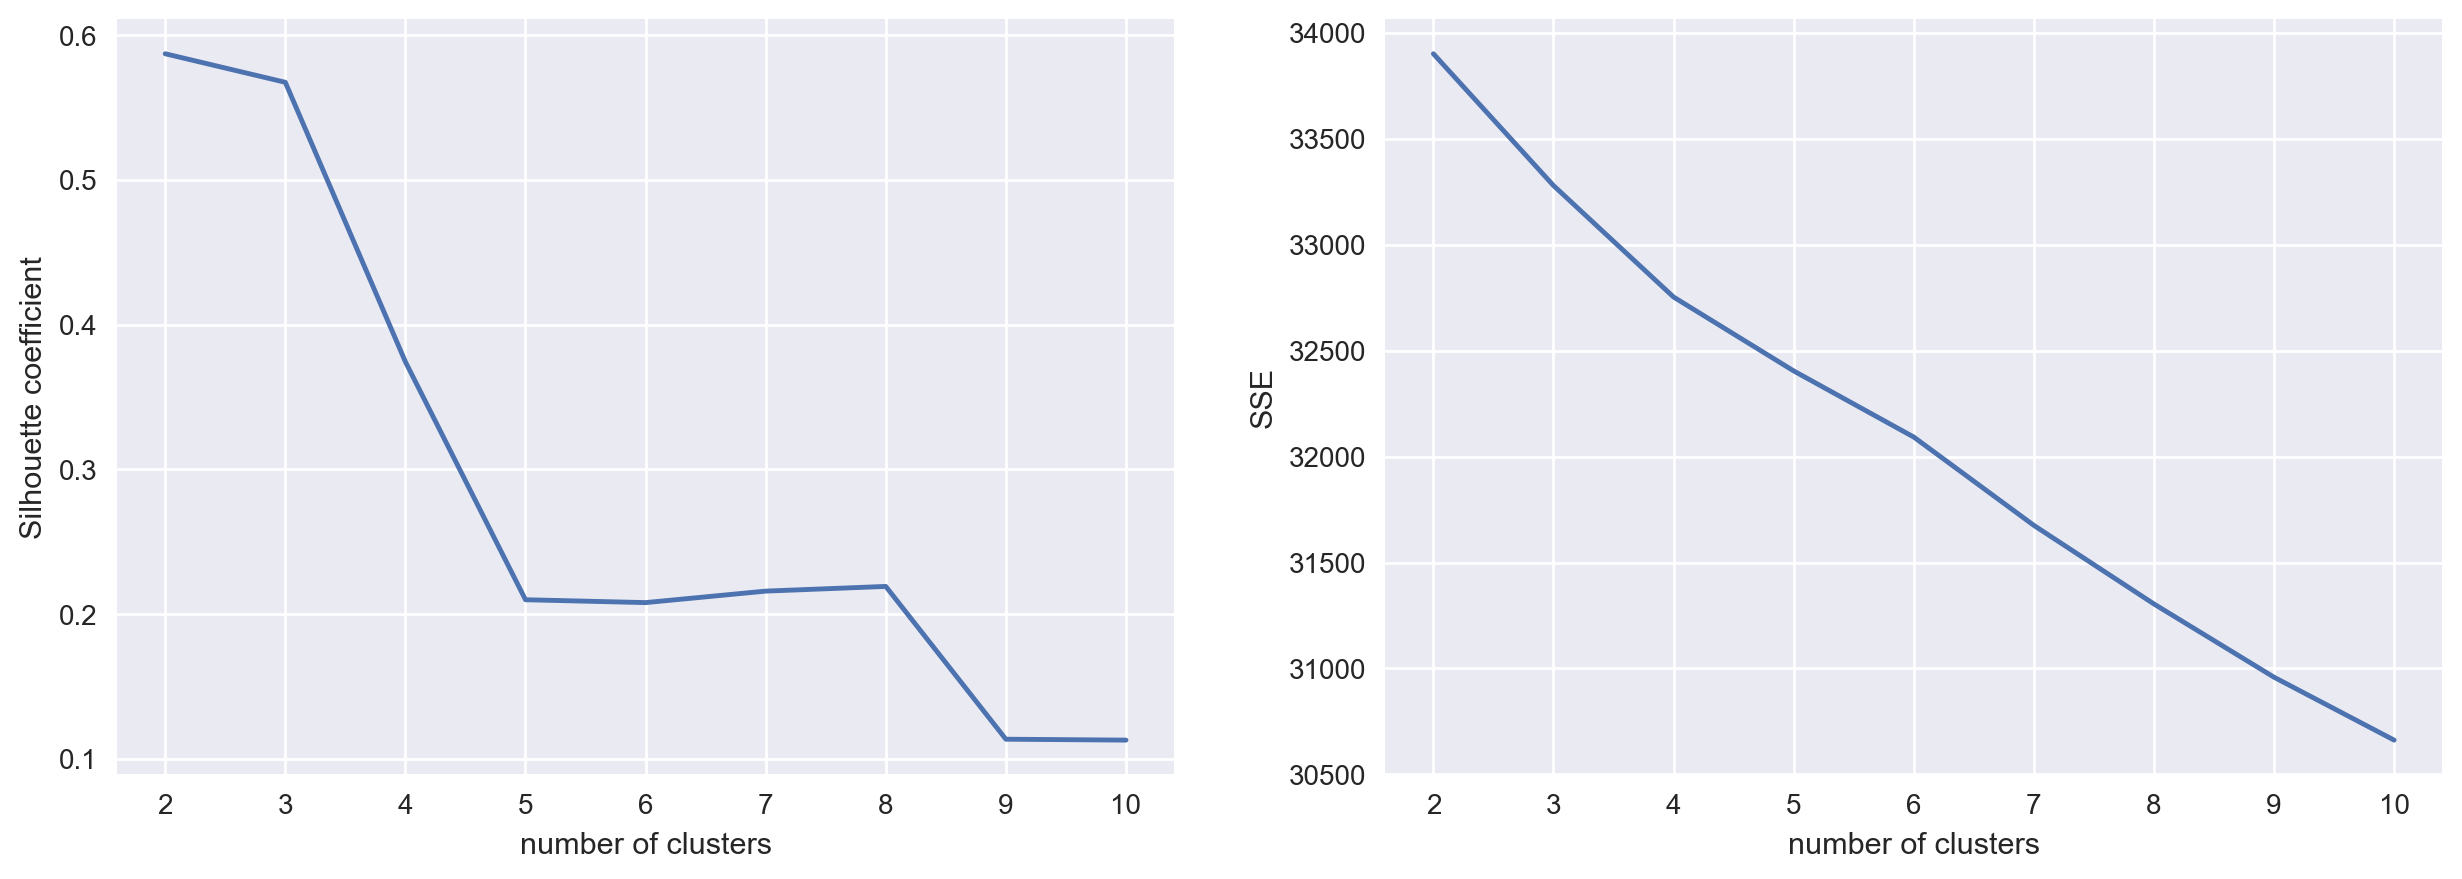

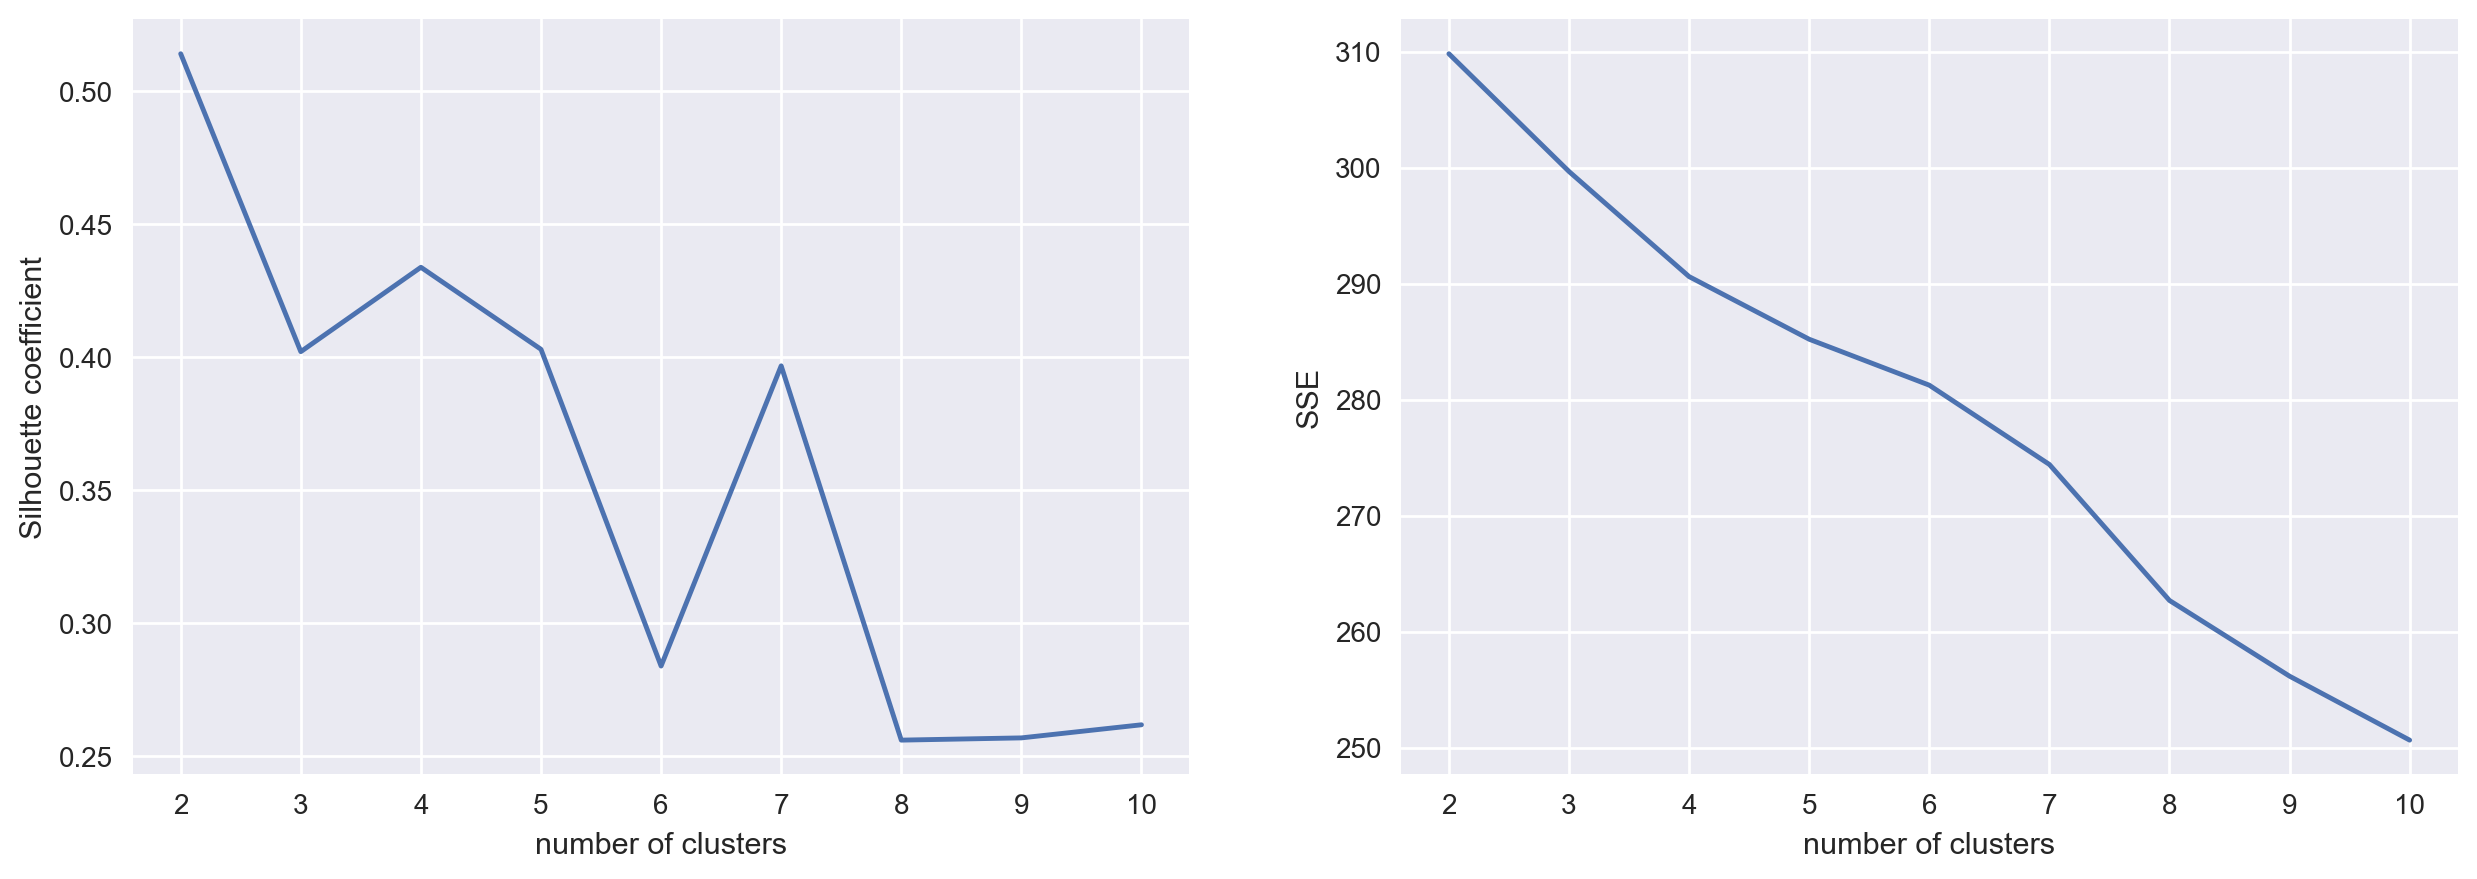

In [234]:
# min_df=0.002, max_feature =100

# Case 4: 'tfidf', 'svd', min_df=0.002, reduced_features=100
lsa_tfidf_0002_100 = KMeansEngine(X, 'tfidf', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_tfidf_0002_100.dimension_reduction('svd', reduction_max_features_=100)
lsa_tfidf_0002_100.KMeans_iterations(10)


# Case 5: 'count', 'svd', min_df=0.002, reduced_features=100
lsa_cv_0002_100 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_cv_0002_100.dimension_reduction('svd', reduction_max_features_=100)
lsa_cv_0002_100.KMeans_iterations(10)


# Case 6: 'count', 'nmf', min_df=0.002, reduced_features=100
nmf_cv_0002_100 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
nmf_cv_0002_100.dimension_reduction('nmf', reduction_max_features_=100)
nmf_cv_0002_100.KMeans_iterations(10)


# Plot for all three cases
lsa_tfidf_0002_100.draw_KMeans_plot()
lsa_cv_0002_100.draw_KMeans_plot()
nmf_cv_0002_100.draw_KMeans_plot()

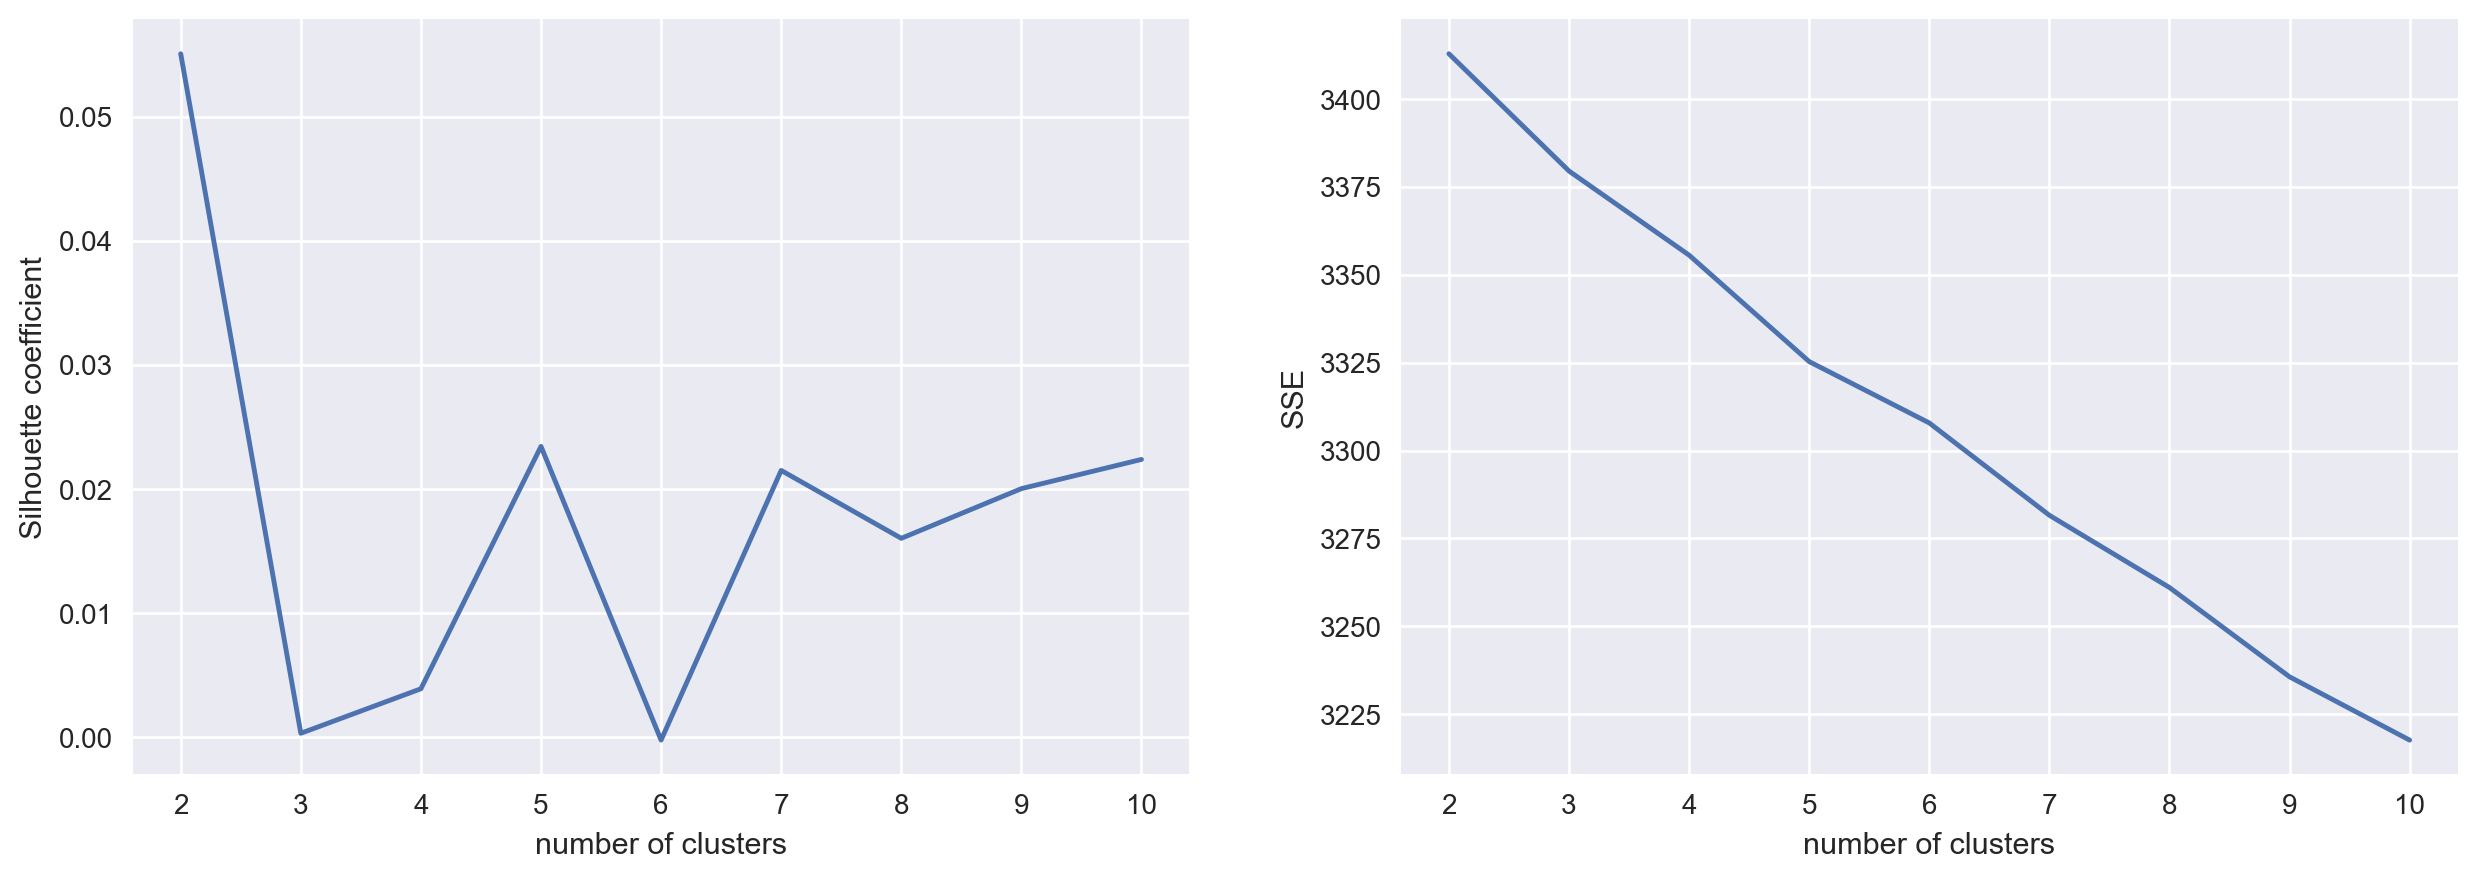

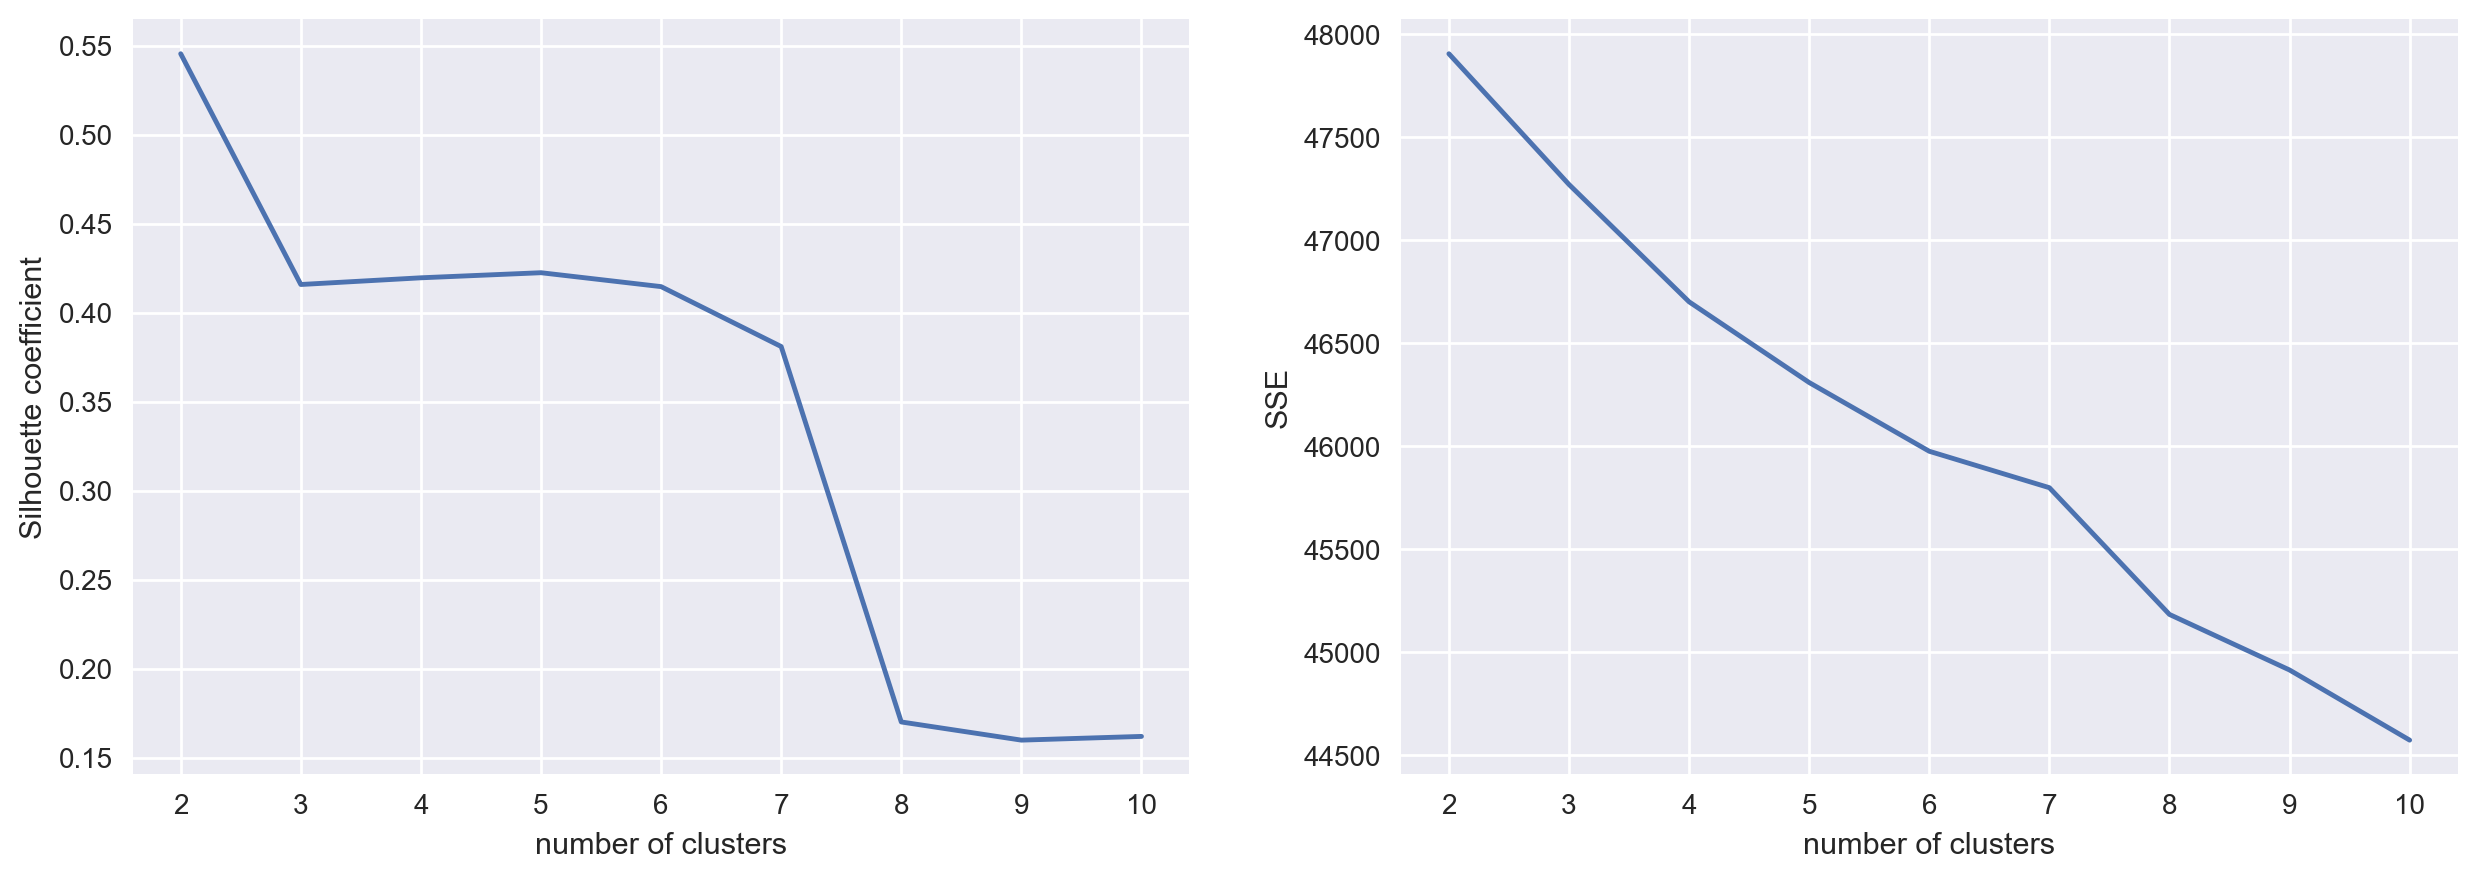

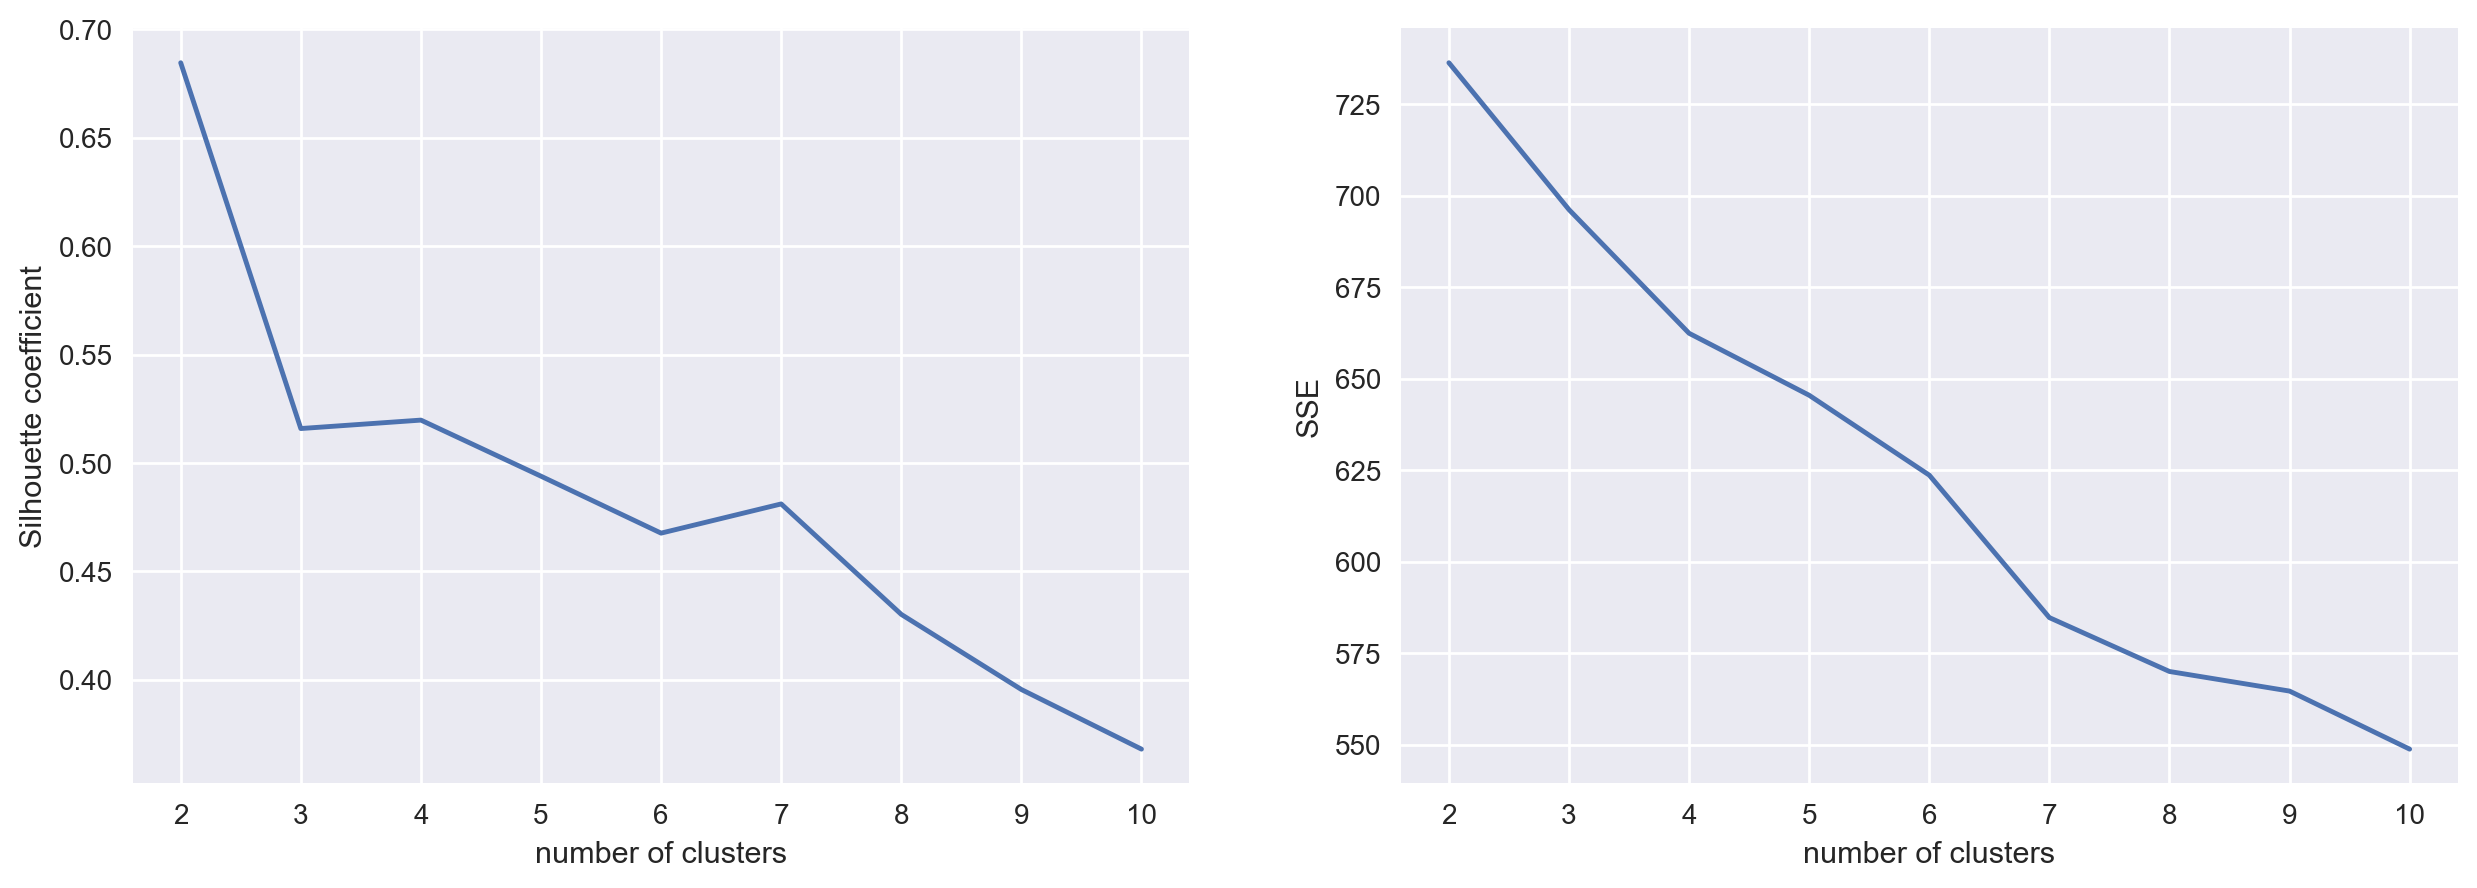

In [235]:
# min_df=0.002, max_feature =200

# Case 7: 'tfidf', 'svd', min_df=0.002, reduced_features=200
lsa_tfidf_0002_200 = KMeansEngine(X, 'tfidf', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_tfidf_0002_200.dimension_reduction('svd', reduction_max_features_=200)
lsa_tfidf_0002_200.KMeans_iterations(10)


# Case 8: 'count', 'svd', min_df=0.002, reduced_features=200
lsa_cv_0002_200 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_cv_0002_200.dimension_reduction('svd', reduction_max_features_=200)
lsa_cv_0002_200.KMeans_iterations(10)


# Case 9: 'count', 'nmf', min_df=0.002, reduced_features=200
nmf_cv_0002_200 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
nmf_cv_0002_200.dimension_reduction('nmf', reduction_max_features_=200)
nmf_cv_0002_200.KMeans_iterations(10)


# Plot for all three cases
lsa_tfidf_0002_200.draw_KMeans_plot()
lsa_cv_0002_200.draw_KMeans_plot()
nmf_cv_0002_200.draw_KMeans_plot()


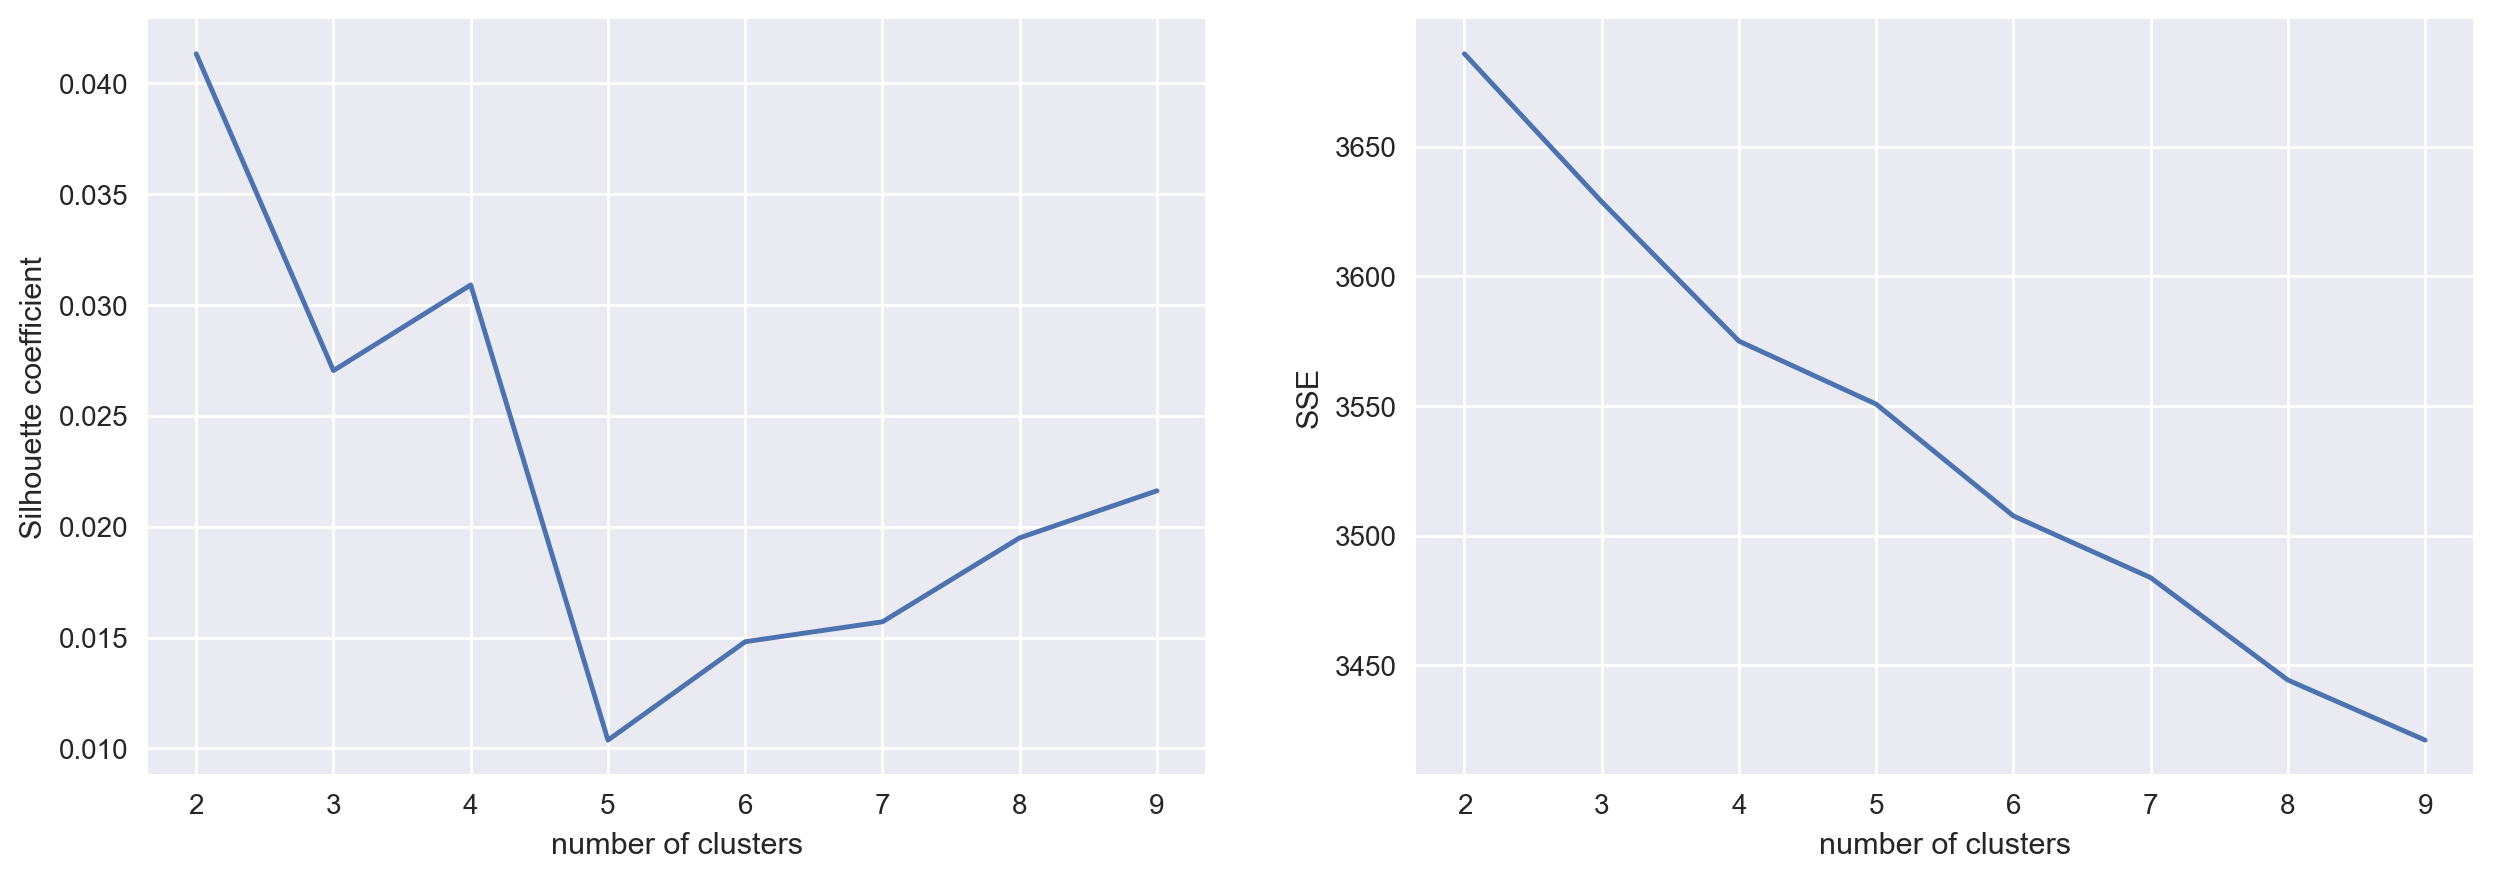

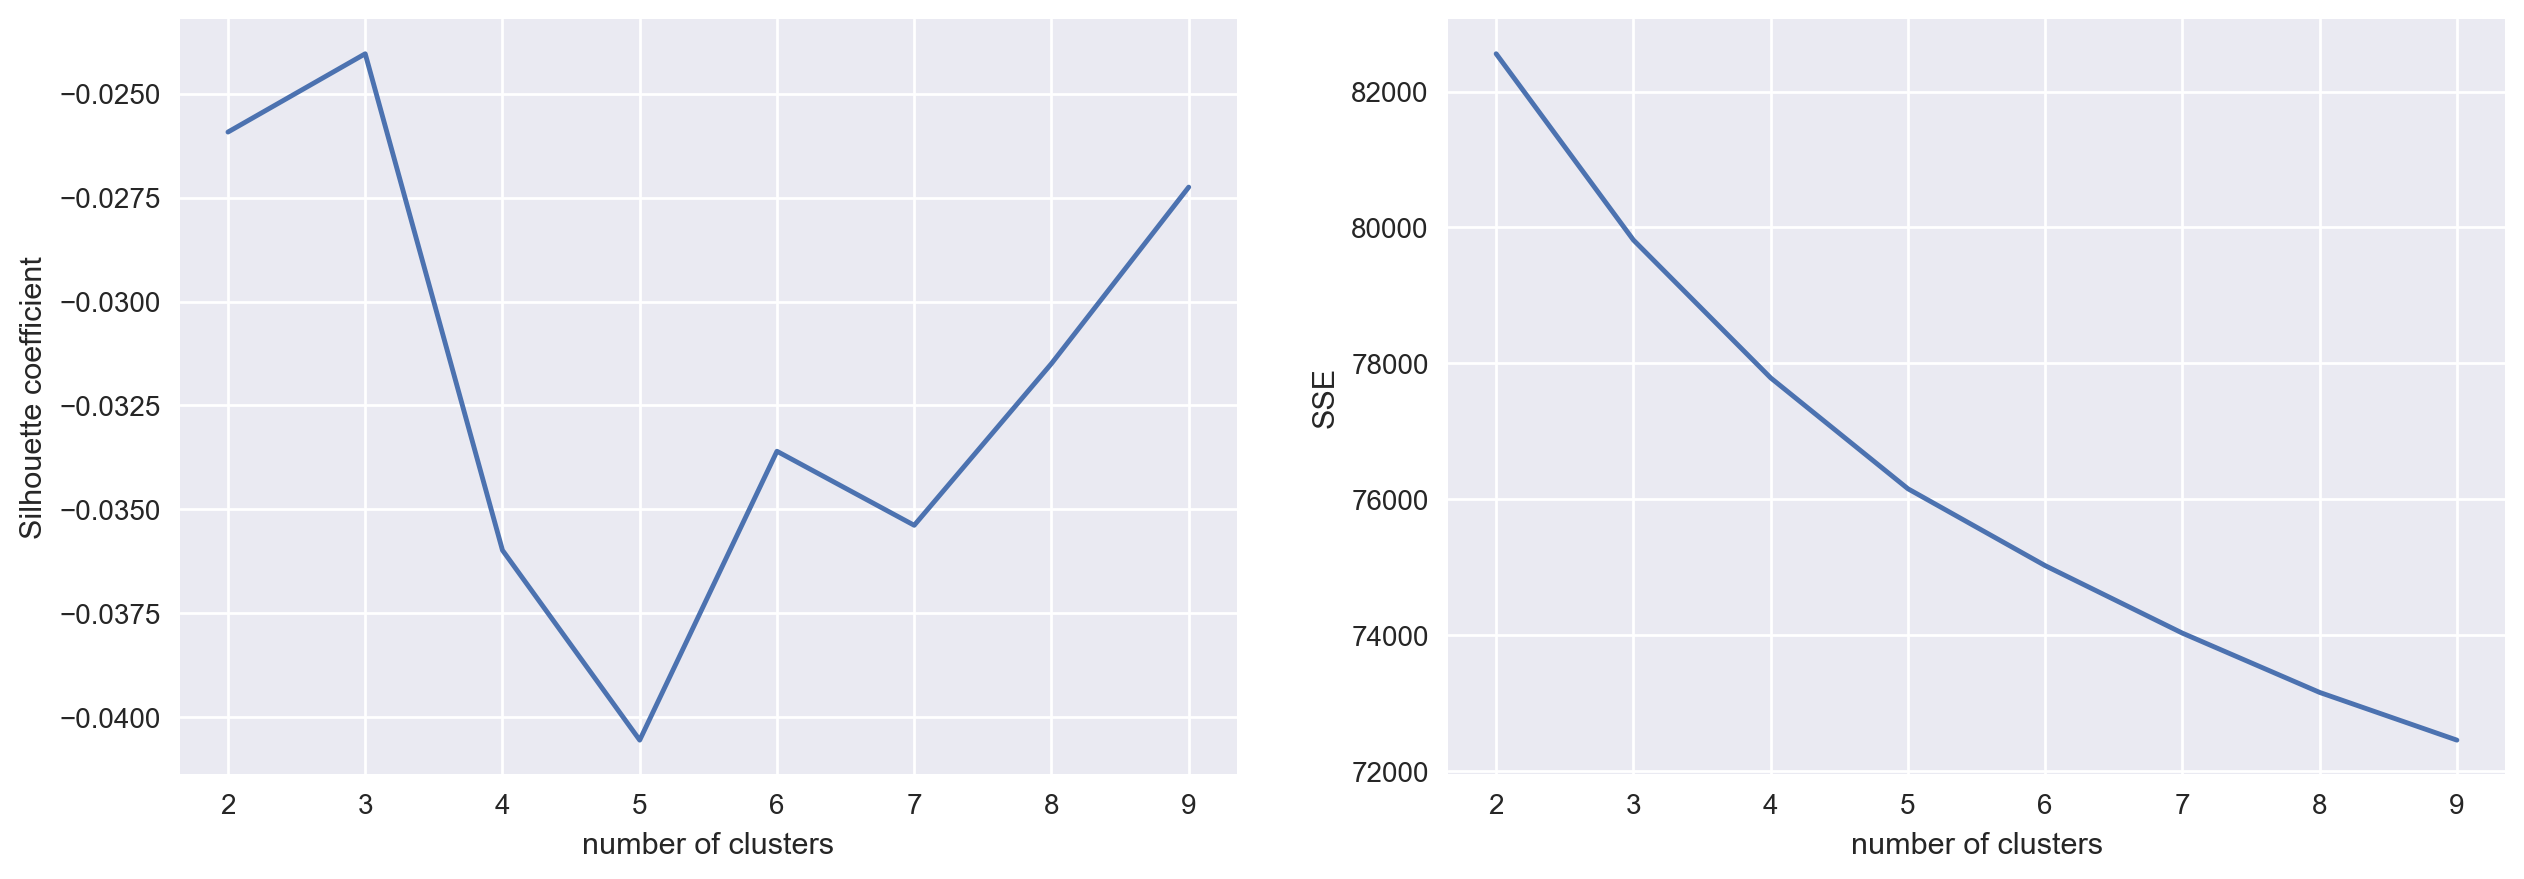

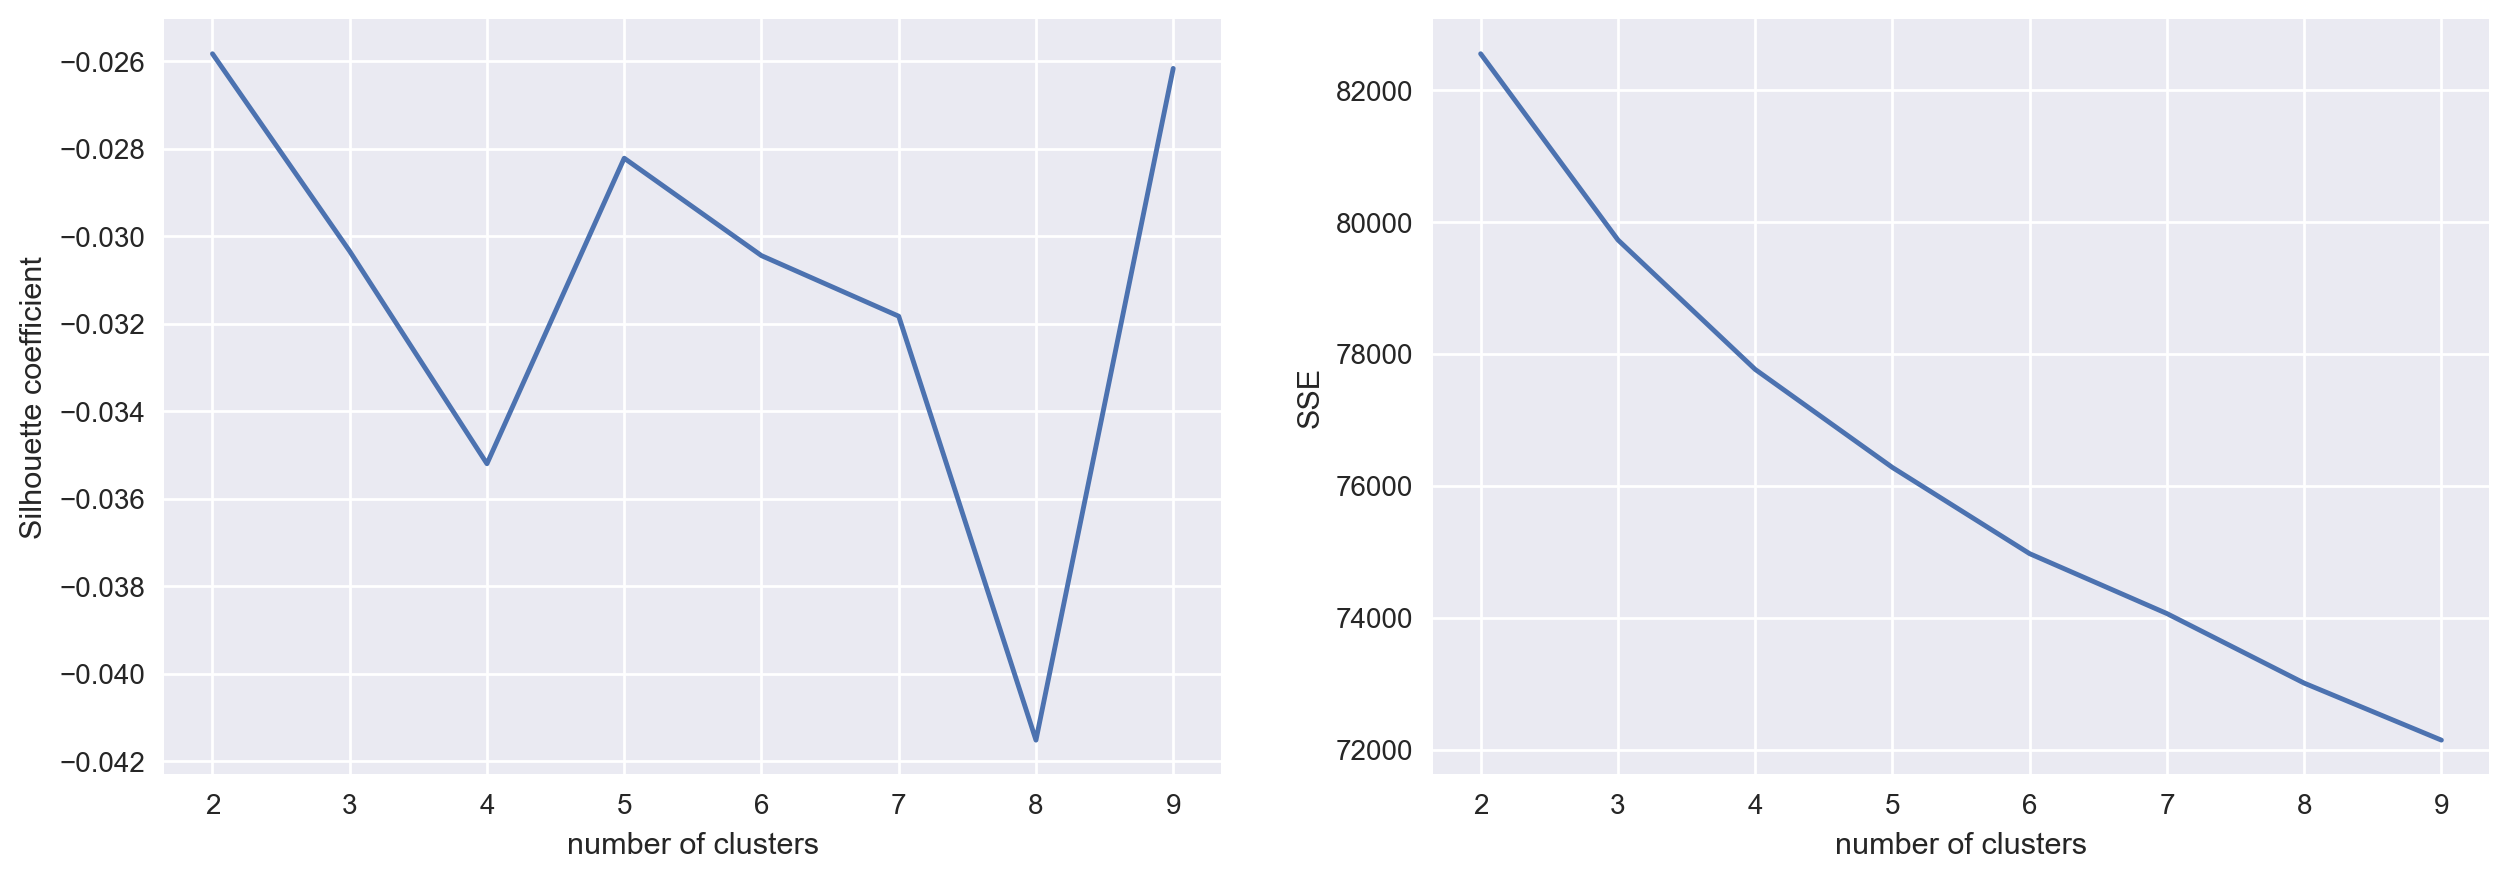

In [160]:
draw_KMeans_plot(Sil_coefs_lsa_tfidf, SSEs_lsa_tfidf)
draw_KMeans_plot(Sil_coefs_lsa_cv, SSEs_lsa_cv)
draw_KMeans_plot(Sil_coefs_nmf_cv, SSEs_nmf_cv)

In [51]:
# This is to load pickle file if data is available,
# or store data when pickle file isn't available

pkl_path = '/Users/xzhou/github/project_files/amazon/review_vector_fit.pkl'

try:    
    with open(pkl_path, 'rb') as pkl_file:
        lsa_tfidf_data = pickle.load(pkl_file)
        lsa_cv_data = pickle.load(pkl_file)
        nmf_cv_data = pickle.load(pkl_file)
except:
    with open(pkl_path, 'wb') as pkl_file:
        pickle.dump(lsa_tfidf_data, pkl_file)
        pickle.dump(lsa_cv_data, pkl_file)
        pickle.dump(nmf_cv_data, pkl_file)
            

In [132]:
# This is to load pickle file if data is available,
# or store data when pickle file isn't available

pkl_path2 = '/Users/xzhou/github/project_files/amazon/amazon_km_scores.pkl'

try:    
    with open(pkl_path2, 'rb') as pkl_file:
        Sil_coefs = pickle.load(pkl_file)
        SSEs = pickle.load(pkl_file)
except:
    with open(pkl_path2, 'wb') as pkl_file:
        pickle.dump(Sil_coefs, pkl_file)
        pickle.dump(SSEs, pkl_file)

In [32]:
km_optimized = KMeans(n_clusters=7, random_state=99, n_jobs=-1)
km_optimized.fit(lsa_tfidf_data)
labels = km_optimized.labels_

In [44]:
labels

array([6, 0, 0, ..., 0, 6, 0], dtype=int32)

In [42]:
labels == 1

array([False, False, False, ..., False, False, False])

In [41]:
cv_data.toarray()[labels == 1]

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [33]:
# how to save the model?
# This is to load pickle file if data is available,
# or store data when pickle file isn't available

# pkl_path3 = '/Users/xzhou/github/project_files/amazon/amazon_km_7clusters.pkl'

# try:    
#     with open(pkl_path2, 'rb') as pkl_file:
#         km_optimized = pickle.load(pkl_file)
# except:
#     with open(pkl_path2, 'wb') as pkl_file:
#         pickle.dump(km_optimized, pkl_file)

In [34]:
centroids = km_optimized.cluster_centers_

In [37]:
centroids.shape

(7, 20)

In [68]:
centroids_reversed = lsa_tfidf.inverse_transform(centroids)

In [69]:
print (centroids_reversed)

[[ 7.72212608e-04  2.00478620e-03  6.98795681e-03 ...  1.96376174e-03
   6.63016635e-04  1.82930320e-03]
 [ 6.74796221e-04  3.44773078e-03  1.06214169e-02 ...  2.48335537e-03
   1.50592339e-04  1.02356018e-03]
 [ 1.35230882e-04 -2.59872452e-06  5.02501606e-03 ...  3.37616974e-03
   2.67414294e-04 -5.07183931e-04]
 ...
 [ 4.10341929e-04  4.69550135e-03  1.71112492e-02 ...  1.40836674e-03
   4.39297509e-04  4.20126386e-03]
 [ 2.69704035e-04  4.85362051e-04  8.23400197e-04 ...  6.34470814e-04
   1.02773149e-05  2.98386370e-03]
 [ 1.00464311e-03  5.30195937e-03  2.28247122e-02 ...  3.26624729e-03
   9.18285382e-04  3.85061743e-03]]


In [65]:
km_optimized.labels_

array([6, 0, 0, ..., 0, 6, 0], dtype=int32)

In [73]:
df

,rating,date,review,review_by_word,word_count,sentiment
2,4,2018-07-31,"Sometimes while playing a game, you can answer...","[Sometimes, while, playing, a, game, ,, you, c...",41,1
3,5,2018-07-31,I have had a lot of fun with this thing. My 4 ...,"[I, have, had, a, lot, of, fun, with, this, th...",38,1
5,5,2018-07-31,I received the echo as a gift. I needed anothe...,"[I, received, the, echo, as, a, gift, ., I, ne...",38,1
6,3,2018-07-31,"Without having a cellphone, I cannot use many ...","[Without, having, a, cellphone, ,, I, can, not...",84,0
7,5,2018-07-31,I think this is the 5th one I've purchased. I'...,"[I, think, this, is, the, 5th, one, I, 've, pu...",45,1
9,5,2018-07-30,Love it! I’ve listened to songs I haven’t hear...,"[Love, it, !, I, ’, ve, listened, to, songs, I...",31,1
10,5,2018-07-30,"I sent it to my 85 year old Dad, and he talks ...","[I, sent, it, to, my, 85, year, old, Dad, ,, a...",17,1
11,5,2018-07-30,I love it! Learning knew things with it eveyda...,"[I, love, it, !, Learning, knew, things, with,...",36,1
12,5,2018-07-30,I purchased this for my mother who is having k...,"[I, purchased, this, for, my, mother, who, is,...",63,1
13,5,2018-07-30,"Love, Love, Love!!","[Love, ,, Love, ,, Love, !, !]",7,1


In [74]:
df['label'] = km_optimized.labels_

In [75]:
df

,rating,date,review,review_by_word,word_count,sentiment,label
2,4,2018-07-31,"Sometimes while playing a game, you can answer...","[Sometimes, while, playing, a, game, ,, you, c...",41,1,6
3,5,2018-07-31,I have had a lot of fun with this thing. My 4 ...,"[I, have, had, a, lot, of, fun, with, this, th...",38,1,0
5,5,2018-07-31,I received the echo as a gift. I needed anothe...,"[I, received, the, echo, as, a, gift, ., I, ne...",38,1,0
6,3,2018-07-31,"Without having a cellphone, I cannot use many ...","[Without, having, a, cellphone, ,, I, can, not...",84,0,0
7,5,2018-07-31,I think this is the 5th one I've purchased. I'...,"[I, think, this, is, the, 5th, one, I, 've, pu...",45,1,0
9,5,2018-07-30,Love it! I’ve listened to songs I haven’t hear...,"[Love, it, !, I, ’, ve, listened, to, songs, I...",31,1,0
10,5,2018-07-30,"I sent it to my 85 year old Dad, and he talks ...","[I, sent, it, to, my, 85, year, old, Dad, ,, a...",17,1,0
11,5,2018-07-30,I love it! Learning knew things with it eveyda...,"[I, love, it, !, Learning, knew, things, with,...",36,1,3
12,5,2018-07-30,I purchased this for my mother who is having k...,"[I, purchased, this, for, my, mother, who, is,...",63,1,0
13,5,2018-07-30,"Love, Love, Love!!","[Love, ,, Love, ,, Love, !, !]",7,1,2


In [76]:
df[df['label']==0]

,rating,date,review,review_by_word,word_count,sentiment,label
3,5,2018-07-31,I have had a lot of fun with this thing. My 4 ...,"[I, have, had, a, lot, of, fun, with, this, th...",38,1,0
5,5,2018-07-31,I received the echo as a gift. I needed anothe...,"[I, received, the, echo, as, a, gift, ., I, ne...",38,1,0
6,3,2018-07-31,"Without having a cellphone, I cannot use many ...","[Without, having, a, cellphone, ,, I, can, not...",84,0,0
7,5,2018-07-31,I think this is the 5th one I've purchased. I'...,"[I, think, this, is, the, 5th, one, I, 've, pu...",45,1,0
9,5,2018-07-30,Love it! I’ve listened to songs I haven’t hear...,"[Love, it, !, I, ’, ve, listened, to, songs, I...",31,1,0
10,5,2018-07-30,"I sent it to my 85 year old Dad, and he talks ...","[I, sent, it, to, my, 85, year, old, Dad, ,, a...",17,1,0
12,5,2018-07-30,I purchased this for my mother who is having k...,"[I, purchased, this, for, my, mother, who, is,...",63,1,0
14,5,2018-07-30,Just what I expected....,"[Just, what, I, expected, ..., .]",6,1,0
17,5,2018-07-30,We have only been using Alexa for a couple of ...,"[We, have, only, been, using, Alexa, for, a, c...",47,1,0
19,4,2018-07-30,I liked the original Echo. This is the same bu...,"[I, liked, the, original, Echo, ., This, is, t...",101,1,0


In [78]:
df[df['label']==6]

,rating,date,review,review_by_word,word_count,sentiment,label
2,4,2018-07-31,"Sometimes while playing a game, you can answer...","[Sometimes, while, playing, a, game, ,, you, c...",41,1,6
21,5,2018-07-30,"We love Alexa! We use her to play music, play ...","[We, love, Alexa, !, We, use, her, to, play, m...",80,1,6
32,5,2018-07-30,She works well. Needs a learning command for ...,"[She, works, well, ., Needs, a, learning, comm...",43,1,6
41,5,2018-07-30,My Android would not allow Alexa to connect. F...,"[My, Android, would, not, allow, Alexa, to, co...",35,1,6
45,5,2018-07-30,Very satisfied with the Echo. Alexa now contro...,"[Very, satisfied, with, the, Echo, ., Alexa, n...",28,1,6
46,2,2018-07-30,"It's like Siri, in fact, Siri answers more acc...","[It, 's, like, Siri, ,, in, fact, ,, Siri, ans...",39,-1,6
53,5,2018-07-30,The sound from this Echo 2nd Generation is phe...,"[The, sound, from, this, Echo, 2nd, Generation...",24,1,6
58,5,2018-07-30,"Love Alexa, bought others for friends","[Love, Alexa, ,, bought, others, for, friends]",7,1,6
59,5,2018-07-30,Love the echo I purchased it for company for m...,"[Love, the, echo, I, purchased, it, for, compa...",38,1,6
76,4,2018-07-30,I bought this because it can control fios tele...,"[I, bought, this, because, it, can, control, f...",145,1,6
